In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 12.1

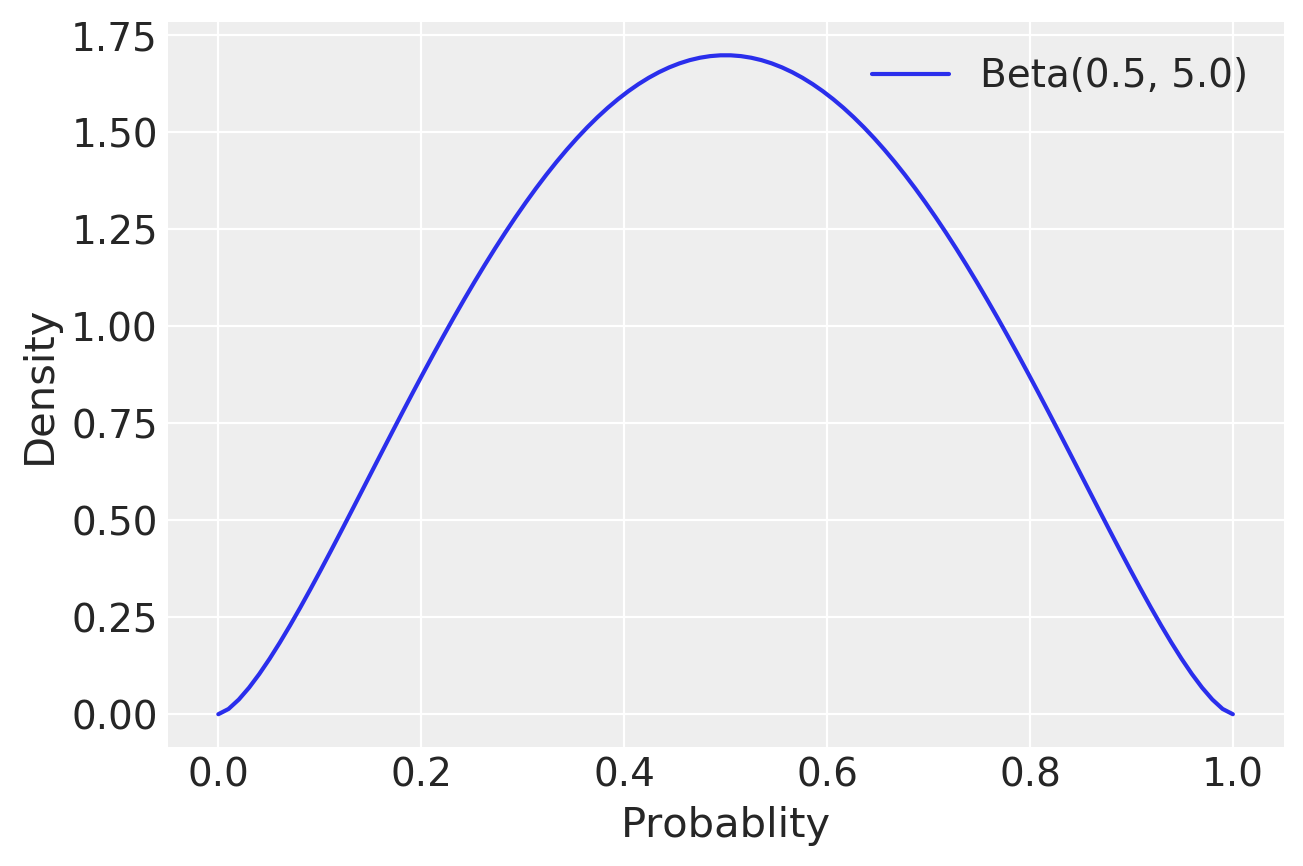

In [3]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 5.0
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot[:, np.newaxis], pbar * theta, (1 - pbar) * theta),
    label=f"Beta({pbar}, {theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

#### Code 12.2

In [4]:
admit_df = pd.read_csv("Data/UCBadmit.csv", sep=";")
N = admit_df.applications.values
gid = (admit_df["applicant.gender"] == "female").astype(int).values
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0.0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1.0)

    theta = pm.Deterministic("theta", phi + 2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))

    A = pm.BetaBinomial(
        "A", pbar * theta, (1.0 - pbar) * theta, N, observed=admit_df.admit.values
    )

    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 12.3

In [6]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.41,-1.18,0.14,0.01,0.01,2720.52,2107.48,2731.31,2358.94,1.0
a[1],-0.33,0.42,-1.00,0.30,0.01,0.01,2928.68,2093.57,2949.06,2334.63,1.0
phi,1.03,0.79,0.00,2.03,0.02,0.01,2785.24,2785.24,1924.51,1206.59,1.0
theta,3.03,0.79,2.00,4.03,0.02,0.01,2785.24,2785.24,1924.51,1206.59,1.0


In [7]:
diff_a = trace_12_1["a"][:, 0] - trace_12_1["a"][:, 1]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
diff_a,-0.13,0.59,-1.05,0.83


#### Code 12.4

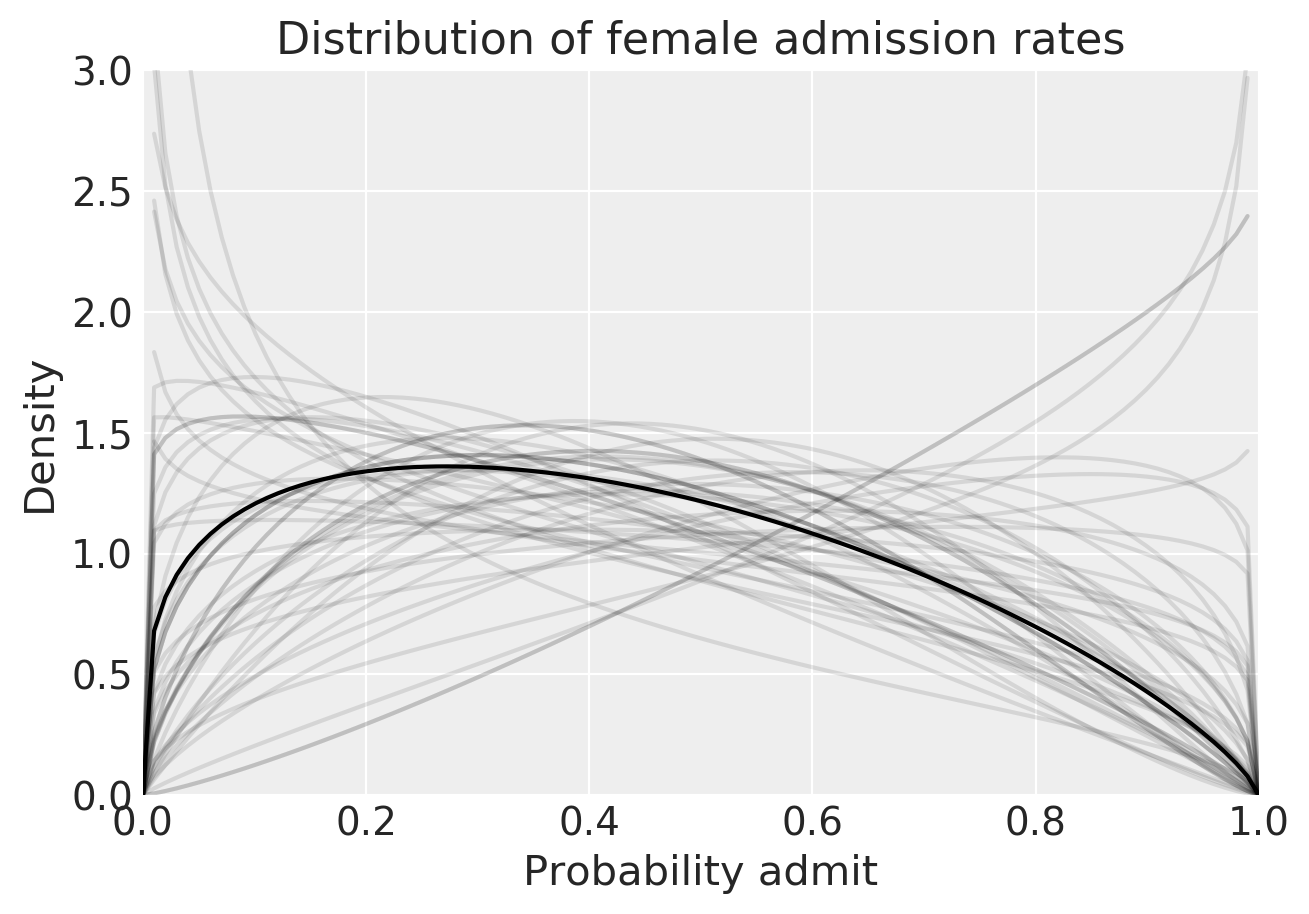

In [8]:
gid = 1
x_plot = np.linspace(0, 1, 100)

# draw posterior mean beta distribution:
pbar_mean = logistic(trace_12_1["a"][:, gid]).mean()
theta_mean = trace_12_1["theta"].mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1.0 - pbar_mean) * theta_mean),
    c="k",
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(trace_12_1["a"][:, gid])[:50] * trace_12_1["theta"][:50],
        (1.0 - logistic(trace_12_1["a"][:, gid])[:50]) * trace_12_1["theta"][:50],
    ),
    c="k",
    alpha=0.1,
)

plt.xlim(0.0, 1.0)
plt.xlabel("Probability admit")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

#### Code 12.5

In [9]:
with m12_1:
    ppc = pm.sample_posterior_predictive(trace_12_1, random_seed=RANDOM_SEED)["A"]
pp_admit = ppc / N

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (12). Passed array should have shape (chains, draws, *shape)
  UserWarning,


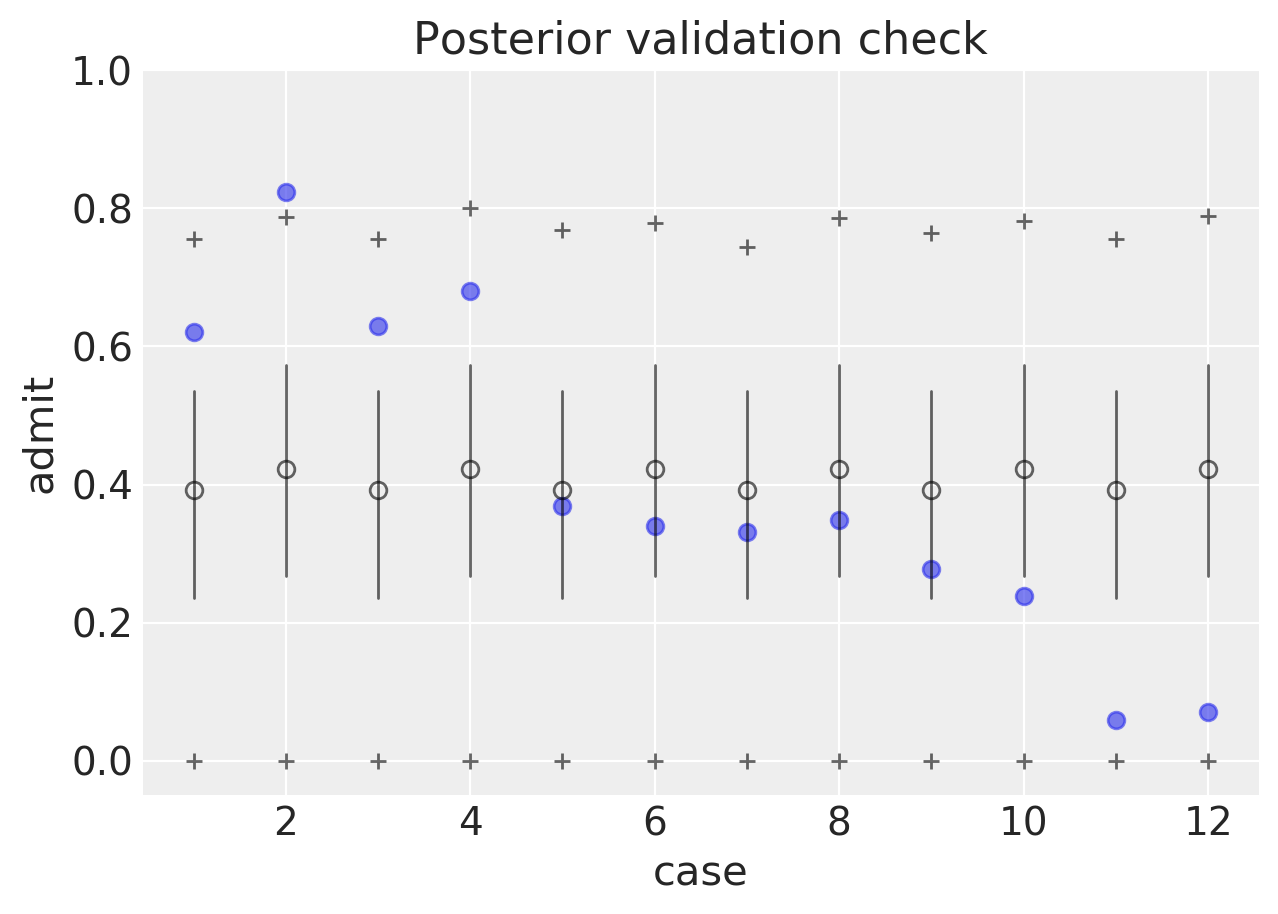

In [10]:
plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(
    range(1, 13), trace_12_1["pbar"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6
)
plt.plot(
    [range(1, 13), range(1, 13)], az.hpd(trace_12_1["pbar"]).T, "k-", lw=1, alpha=0.6
)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### Code 12.6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, g, b, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 14 seconds.


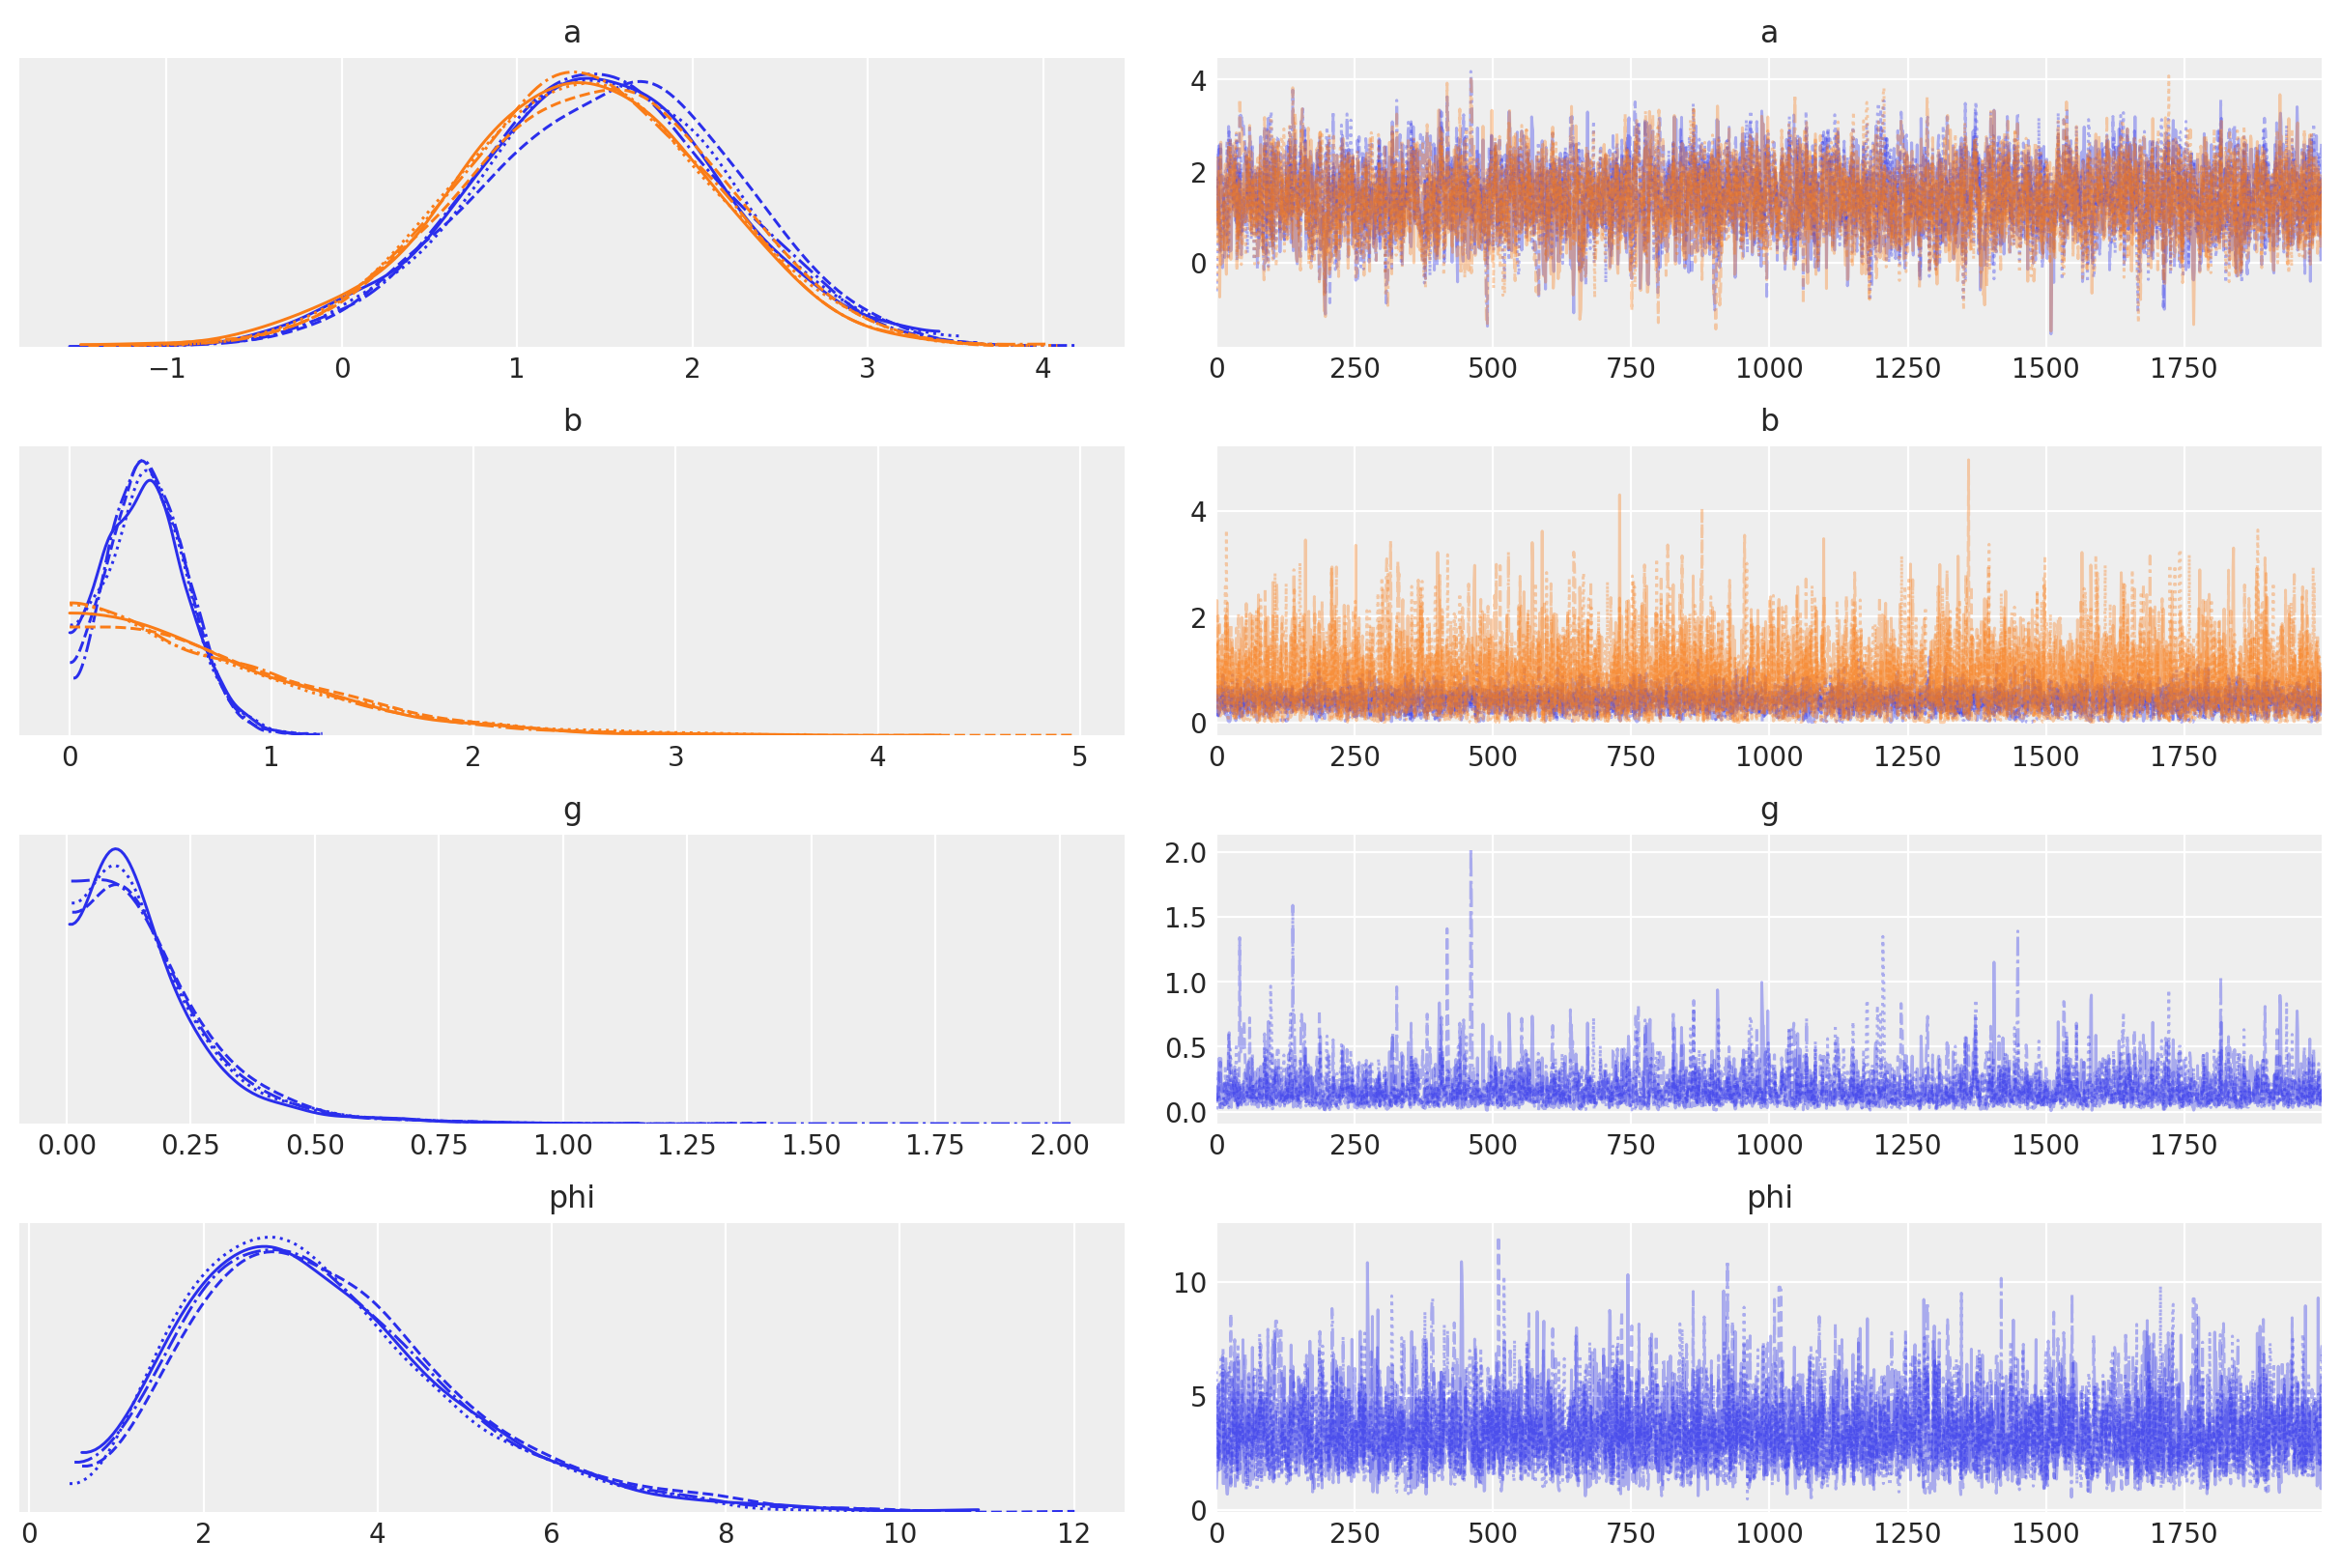

In [11]:
dk = pd.read_csv("Data/Kline", sep=";")
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0
cid = (dk.contact == "high").astype(int).values

with pm.Model() as m12_2:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)

    lam = (tt.exp(a[cid]) * P ** b[cid]) / g

    T = pm.NegativeBinomial("total_tools", lam, phi, observed=dk.total_tools)

    trace_12_2 = pm.sample(2000, tune=3000, target_accept=0.9, random_seed=RANDOM_SEED)
az.plot_trace(trace_12_2, compact=True);

#### Code 12.7

In [12]:
# define parameters
PROB_DRINK = 0.2  # 20% of days
RATE_WORK = 1.0  # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
drink = np.random.binomial(1, PROB_DRINK, size=N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 12.8

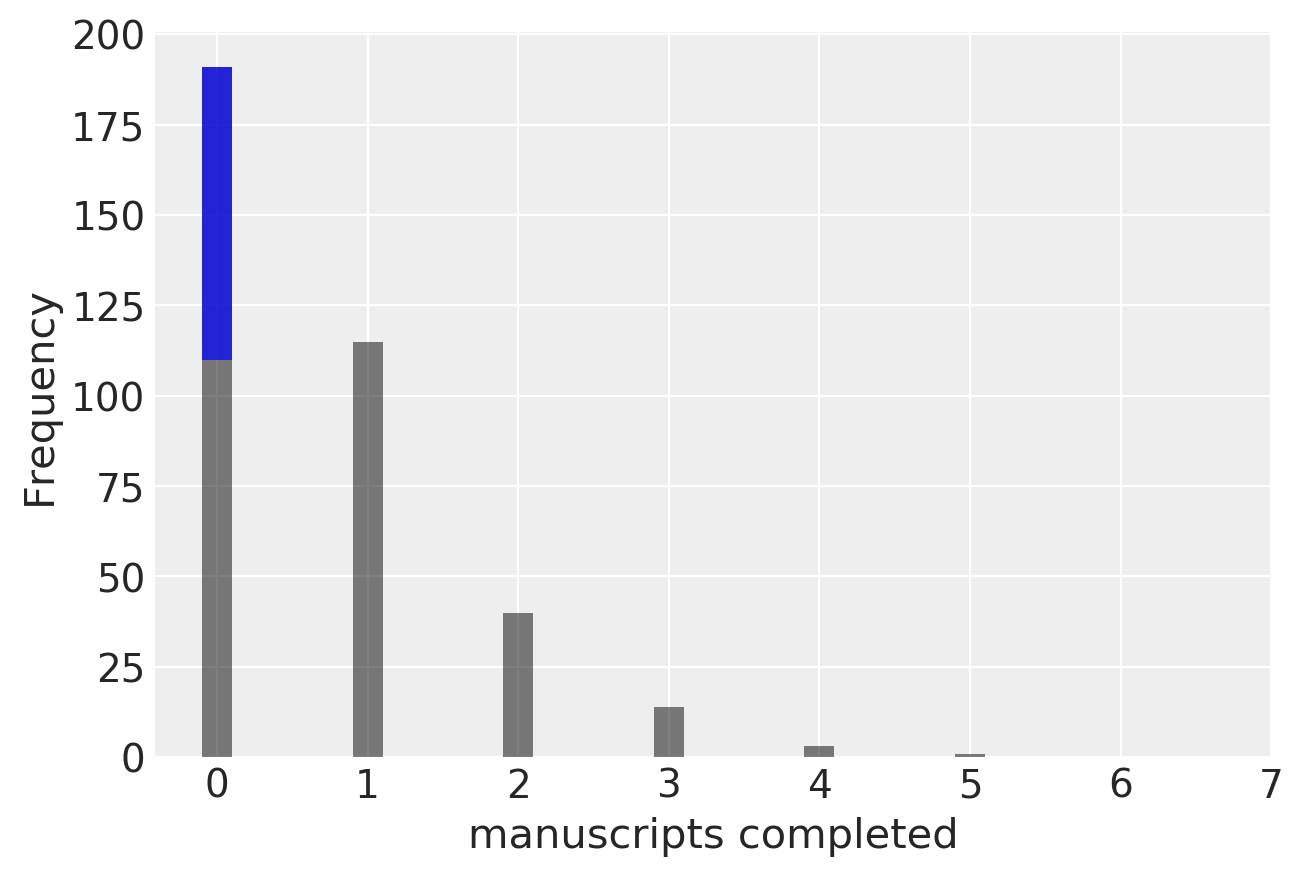

In [13]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.2, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color="b", alpha=0.7)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

#### Code 12.9

In [14]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_12_3 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
az.summary(trace_12_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.88639247778891, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ap,-1.56,0.47,-2.21,-0.82,0.01,0.01,1025.75,1012.07,1072.37,1364.57,1.0
al,-0.11,0.10,-0.26,0.04,0.00,0.00,1083.10,1083.10,1085.54,1269.33,1.0


#### Code 12.10

In [15]:
logistic(trace_12_3["ap"]).mean()  # probability drink

0.183320338167009

In [16]:
np.exp(trace_12_3["al"]).mean()  # rate finish manuscripts, when not drinking

0.8955006158155626

#### Code 12.11

Stan-related

#### Code 12.12

In [17]:
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";")
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### Code 12.13

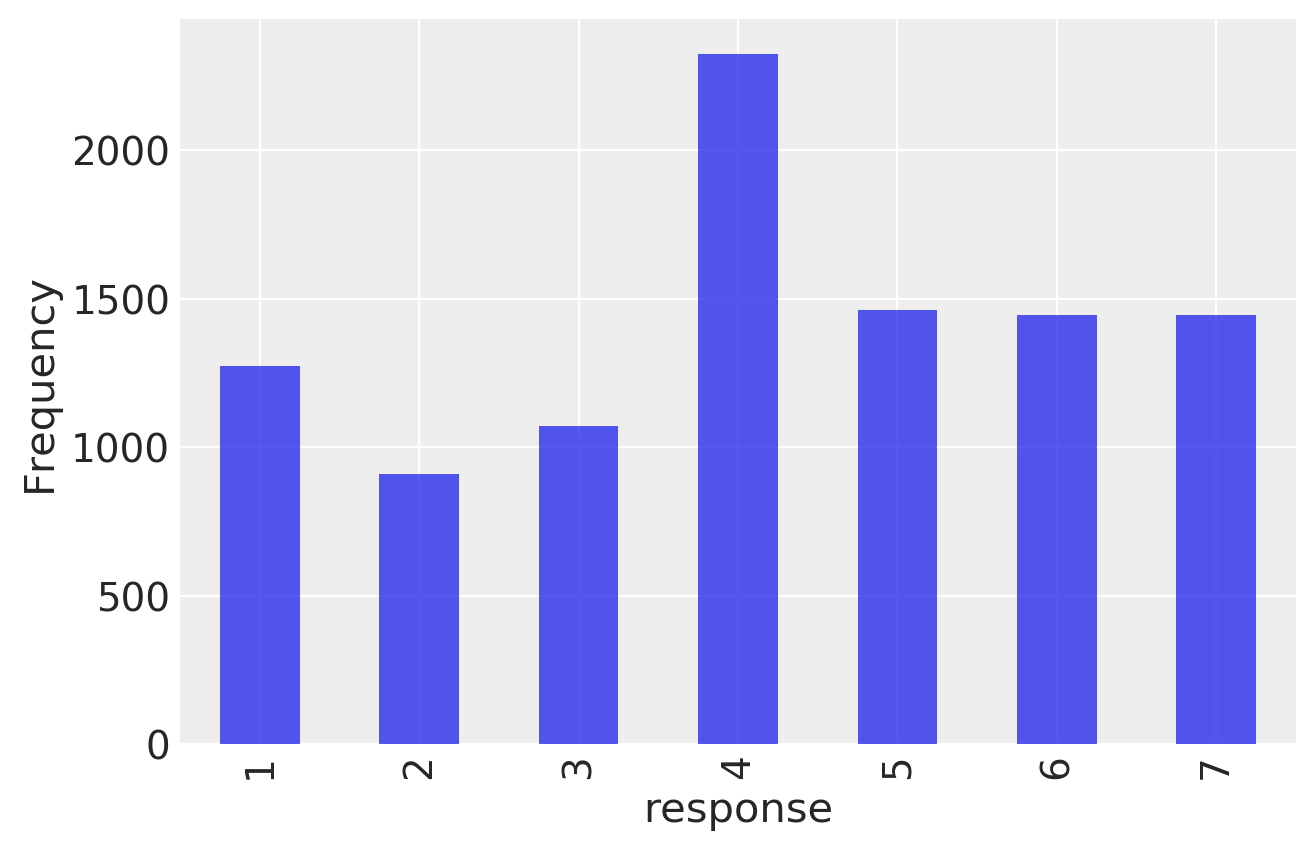

In [18]:
ax = trolley_df.response.value_counts(sort=False).plot(kind="bar", alpha=0.8)
ax.set_xlabel("response")
ax.set_ylabel("Frequency");

#### Code 12.14

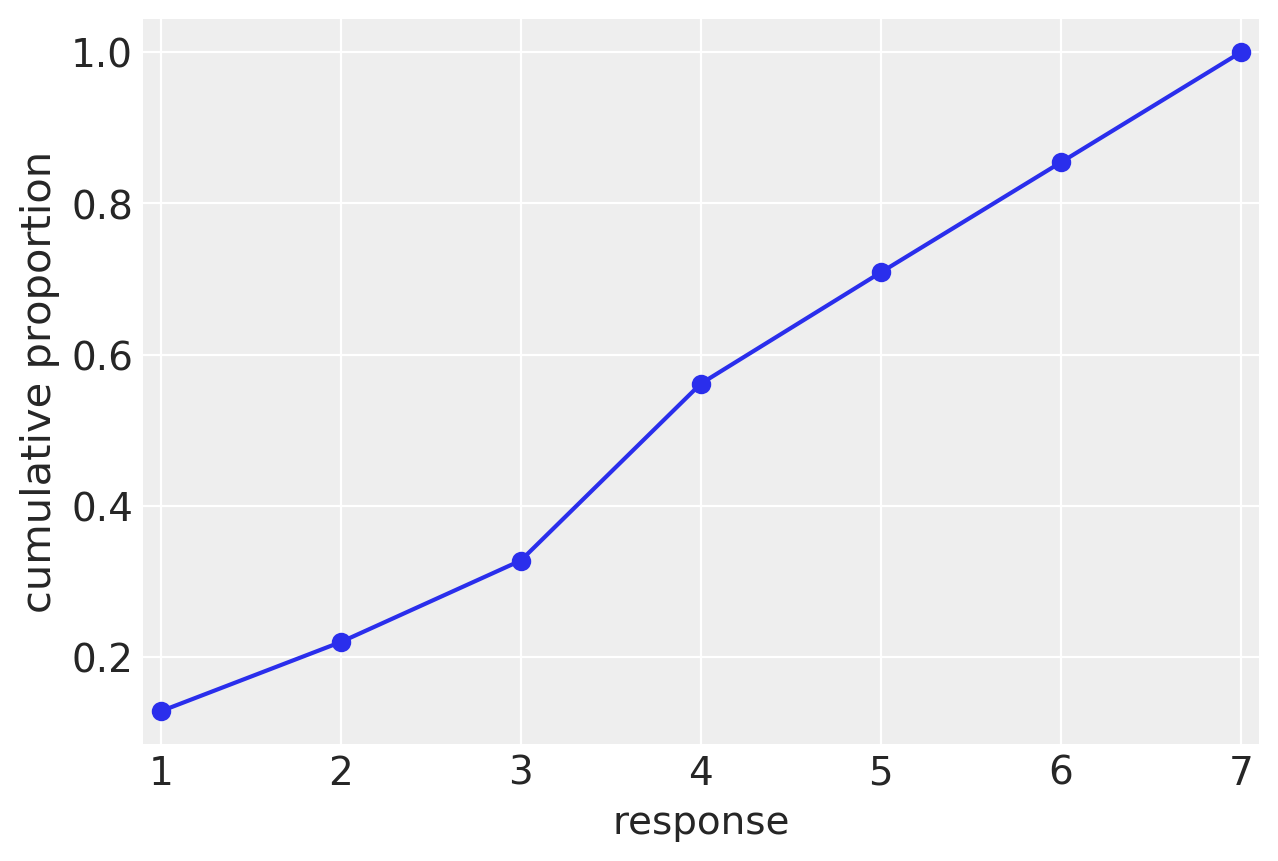

In [19]:
ax = (
    trolley_df.response.value_counts(normalize=True, sort=False)
    .cumsum()
    .plot(marker="o")
)

ax.set_xlim(0.9, 7.1)
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion");

#### Code 12.15

In [20]:
lco = (
    trolley_df.response.value_counts(normalize=True, sort=False)
    .cumsum()
    .apply(sp.special.logit)
)
lco.round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

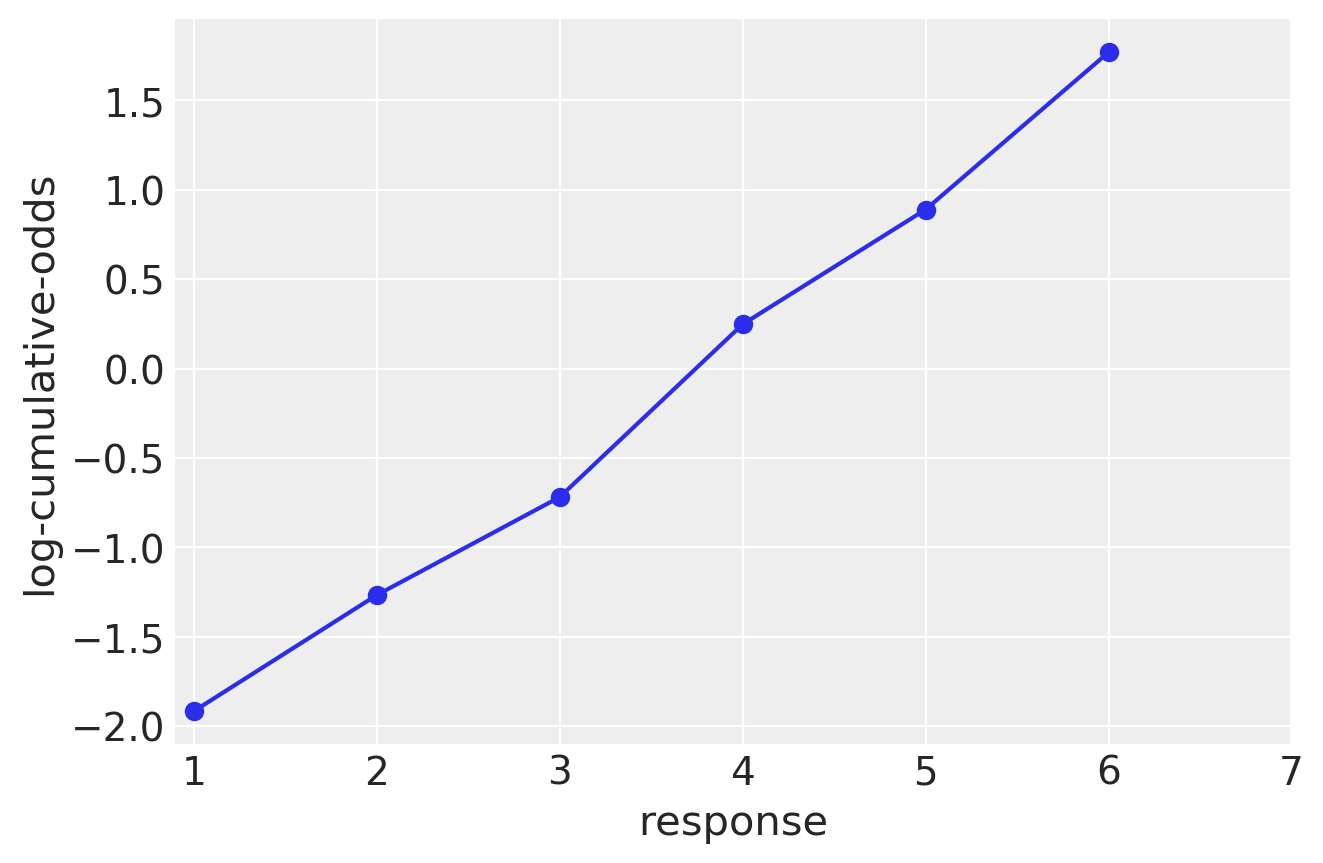

In [21]:
ax = lco.plot(marker="o")
ax.set_xlim(0.9, 7)
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative-odds");

#### Code 12.16 / 17

In [22]:
with pm.Model() as m12_4:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=trolley_df.response.values - 1)

#### Code 12.18

In [23]:
with m12_4:
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.92,0.03,-1.96,-1.87,0.0,0.0,4108.18,4107.11,4102.33,2859.92,1.0
cutpoints[1],-1.27,0.02,-1.30,-1.23,0.0,0.0,4377.68,4377.22,4390.13,3598.82,1.0
cutpoints[2],-0.72,0.02,-0.75,-0.68,0.0,0.0,4395.88,4390.47,4393.18,3224.14,1.0
cutpoints[3],0.25,0.02,0.22,0.28,0.0,0.0,4668.75,4667.76,4670.18,3652.89,1.0
cutpoints[4],0.89,0.02,0.86,0.93,0.0,0.0,4934.38,4934.38,4928.71,3748.98,1.0
cutpoints[5],1.77,0.03,1.73,1.82,0.0,0.0,5131.93,5131.93,5131.13,3735.04,1.0


#### Code 12.19

In [24]:
logistic(trace_12_4["cutpoints"]).mean(0).round(3)

array([0.128, 0.22 , 0.328, 0.562, 0.709, 0.854])

#### Code 12.20

In [25]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]


pk = ordered_logistic_proba(trace_12_4["cutpoints"].mean(axis=0))
pk.round(2)

array([0.13, 0.09, 0.11, 0.23, 0.15, 0.15, 0.15])

#### Code 12.21

In [26]:
(pk * np.arange(1, 8)).sum()

4.199279203356119

#### Code 12.22

In [27]:
pk = ordered_logistic_proba(trace_12_4["cutpoints"].mean(axis=0) - 0.5)
pk.round(2)

array([0.08, 0.06, 0.08, 0.21, 0.16, 0.18, 0.22])

#### Code 12.23

In [28]:
(pk * np.arange(1, 8)).sum()

4.729714968602838

#### Code 12.24

In [29]:
R = trolley_df.response.values - 1

with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", trolley_df.action.values)
    I = pm.Data("I", trolley_df.intention.values)
    C = pm.Data("C", trolley_df.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED)

idata = az.from_pymc3(trace_12_5)
az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bIC,-1.24,0.10,-1.39,-1.08,0.0,0.0,2580.11,2578.04,2586.18,2613.44,1.0
bIA,-0.43,0.08,-0.56,-0.31,0.0,0.0,2181.93,2181.93,2208.31,2787.54,1.0
bC,-0.34,0.07,-0.45,-0.23,0.0,0.0,2365.23,2352.44,2356.89,2724.86,1.0
bI,-0.29,0.06,-0.40,-0.21,0.0,0.0,1801.23,1801.23,1806.47,2388.10,1.0
bA,-0.47,0.05,-0.55,-0.38,0.0,0.0,2344.58,2321.42,2348.69,2861.52,1.0


#### Code 12.25

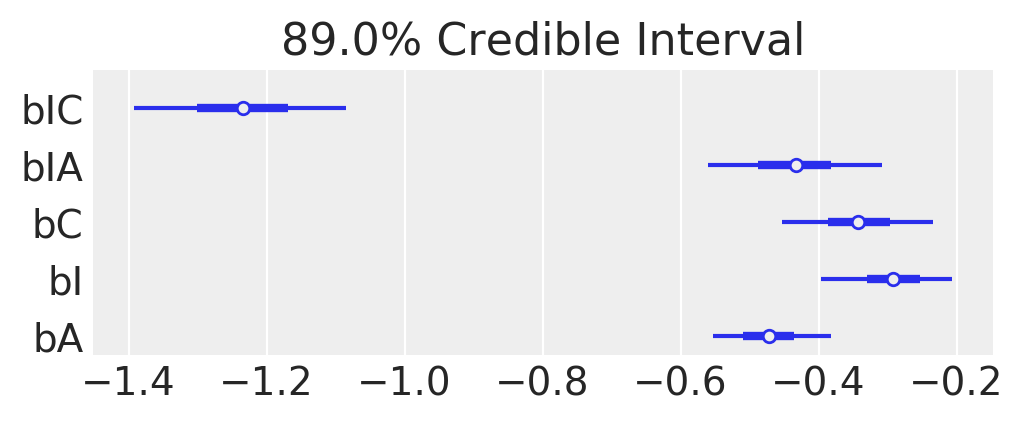

In [30]:
az.plot_forest(
    idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(5, 2), combined=True
);

#### Code 12.26 - 28

In [31]:
# Observed cum probs:
p_obs = (
    trolley_df.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [32]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [33]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

In [34]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.
    
    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

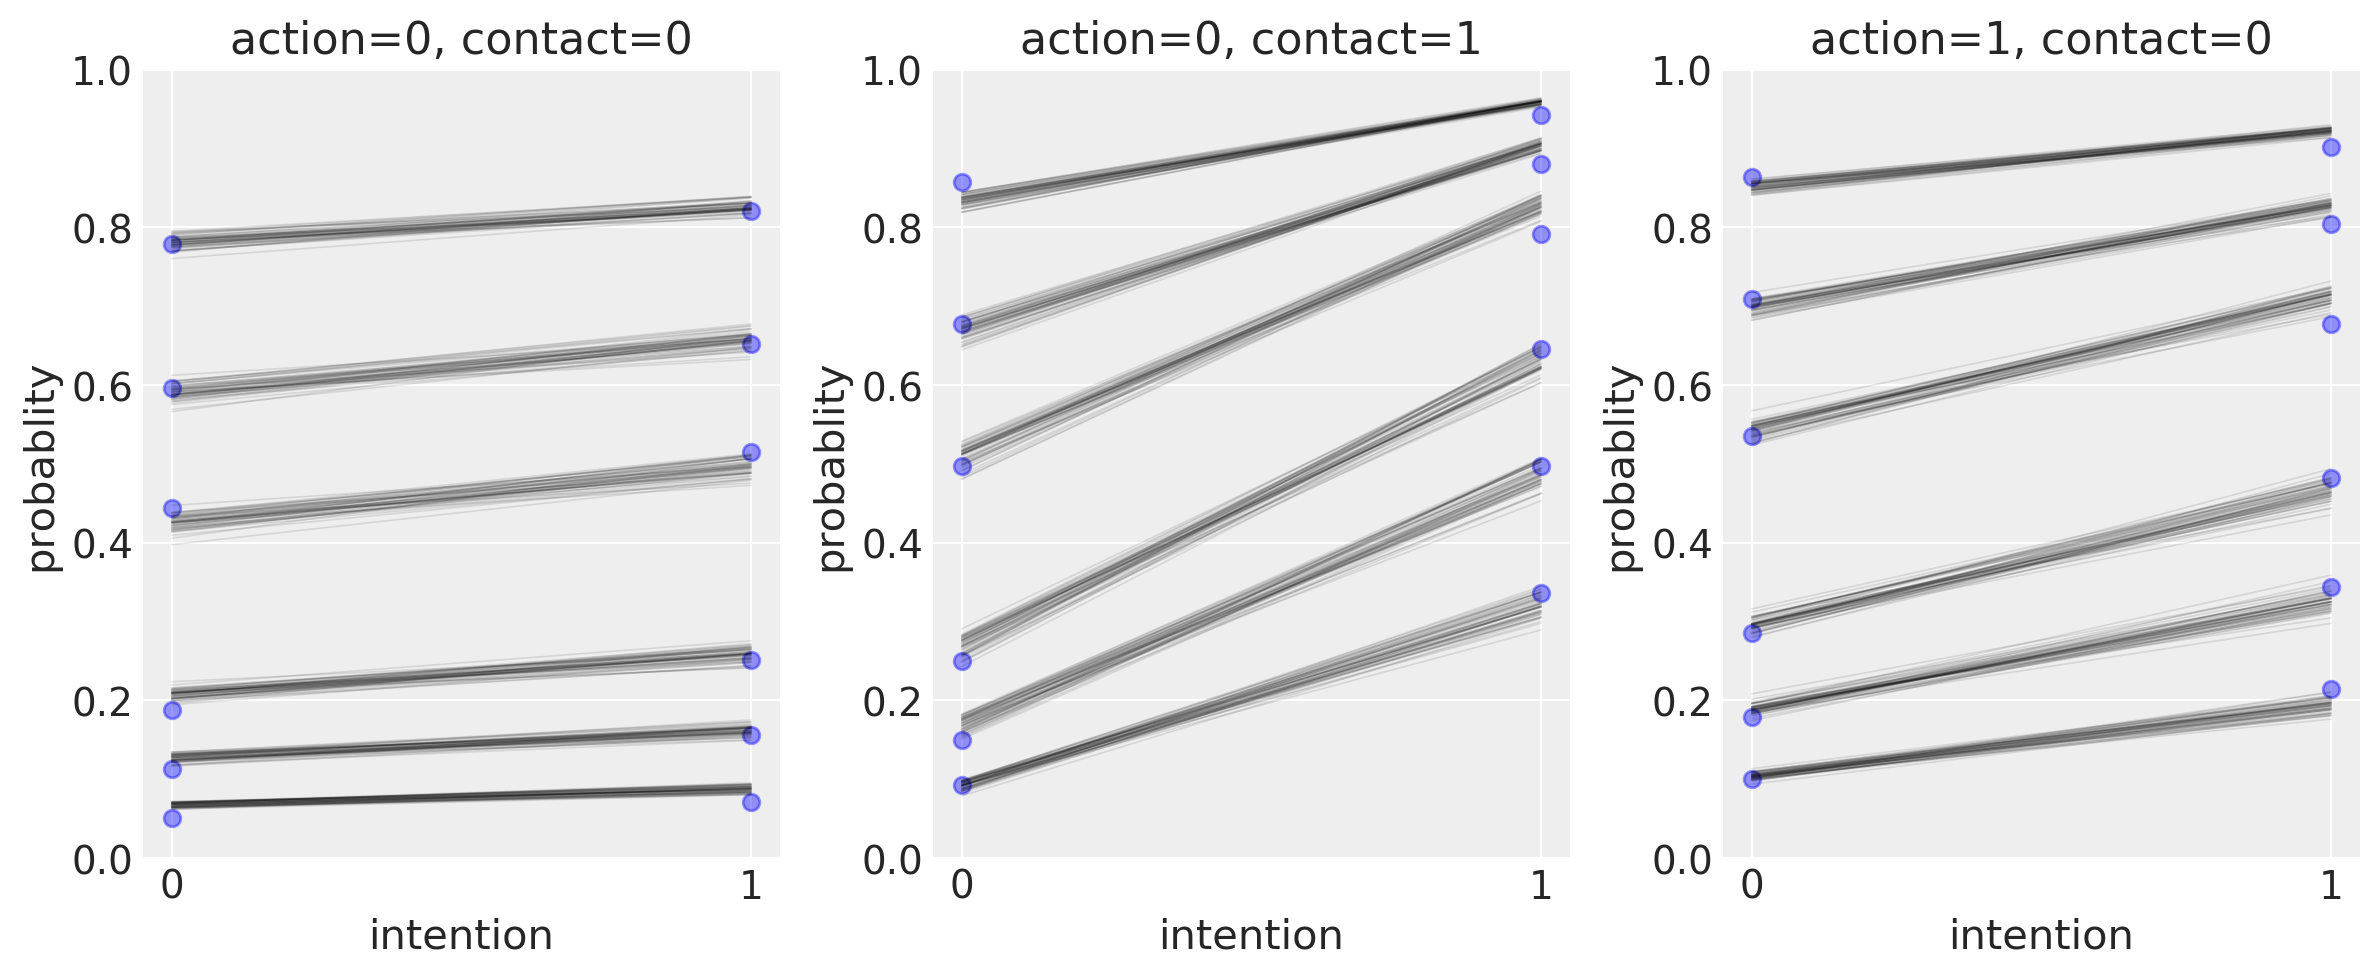

In [35]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

#### Code 12.29

In [36]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )["resp_obs"]

resp_df = pd.DataFrame(pp_resp).T
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

0     1     2     3     4     5     6     7     \
action contact intention                                                   
0      0       0             2     4     3     5     2     4     5     3   
               1             3     6     5     1     6     5     6     3   
       1       0             0     1     4     3     2     0     6     4   
               1             0     4     5     5     1     3     6     2   
1      0       0             3     4     1     3     6     2     2     5   
               1             3     3     1     0     4     3     4     5   

                          8     9     ...  3990  3991  3992  3993  3994  3995  \
action contact intention              ...                                       
0      0       0             6     3  ...     0     4     4     2     3     3   
               1             1     3  ...     2     5     6     3     0     0   
       1       0             3     5  ...     0     2     1     3     1     3   
               1             3     3  ...     2     2     3     0     3     3   
1      0       0             6     2  ...     4     5     0     0     3     5   
               1             6     2  ...     5     2     1     6     5     0   

                          3996  3997  3998  3999  
action contact intention                          
0      0       0             5     1     4     3  
               1             1     5     6     6  
       1       0             5     4     2     5  
               1             2     0     0     2  
1      0       0             1     3     3     6  
               1             3     3     4     4  

[6 rows x 4000 columns]

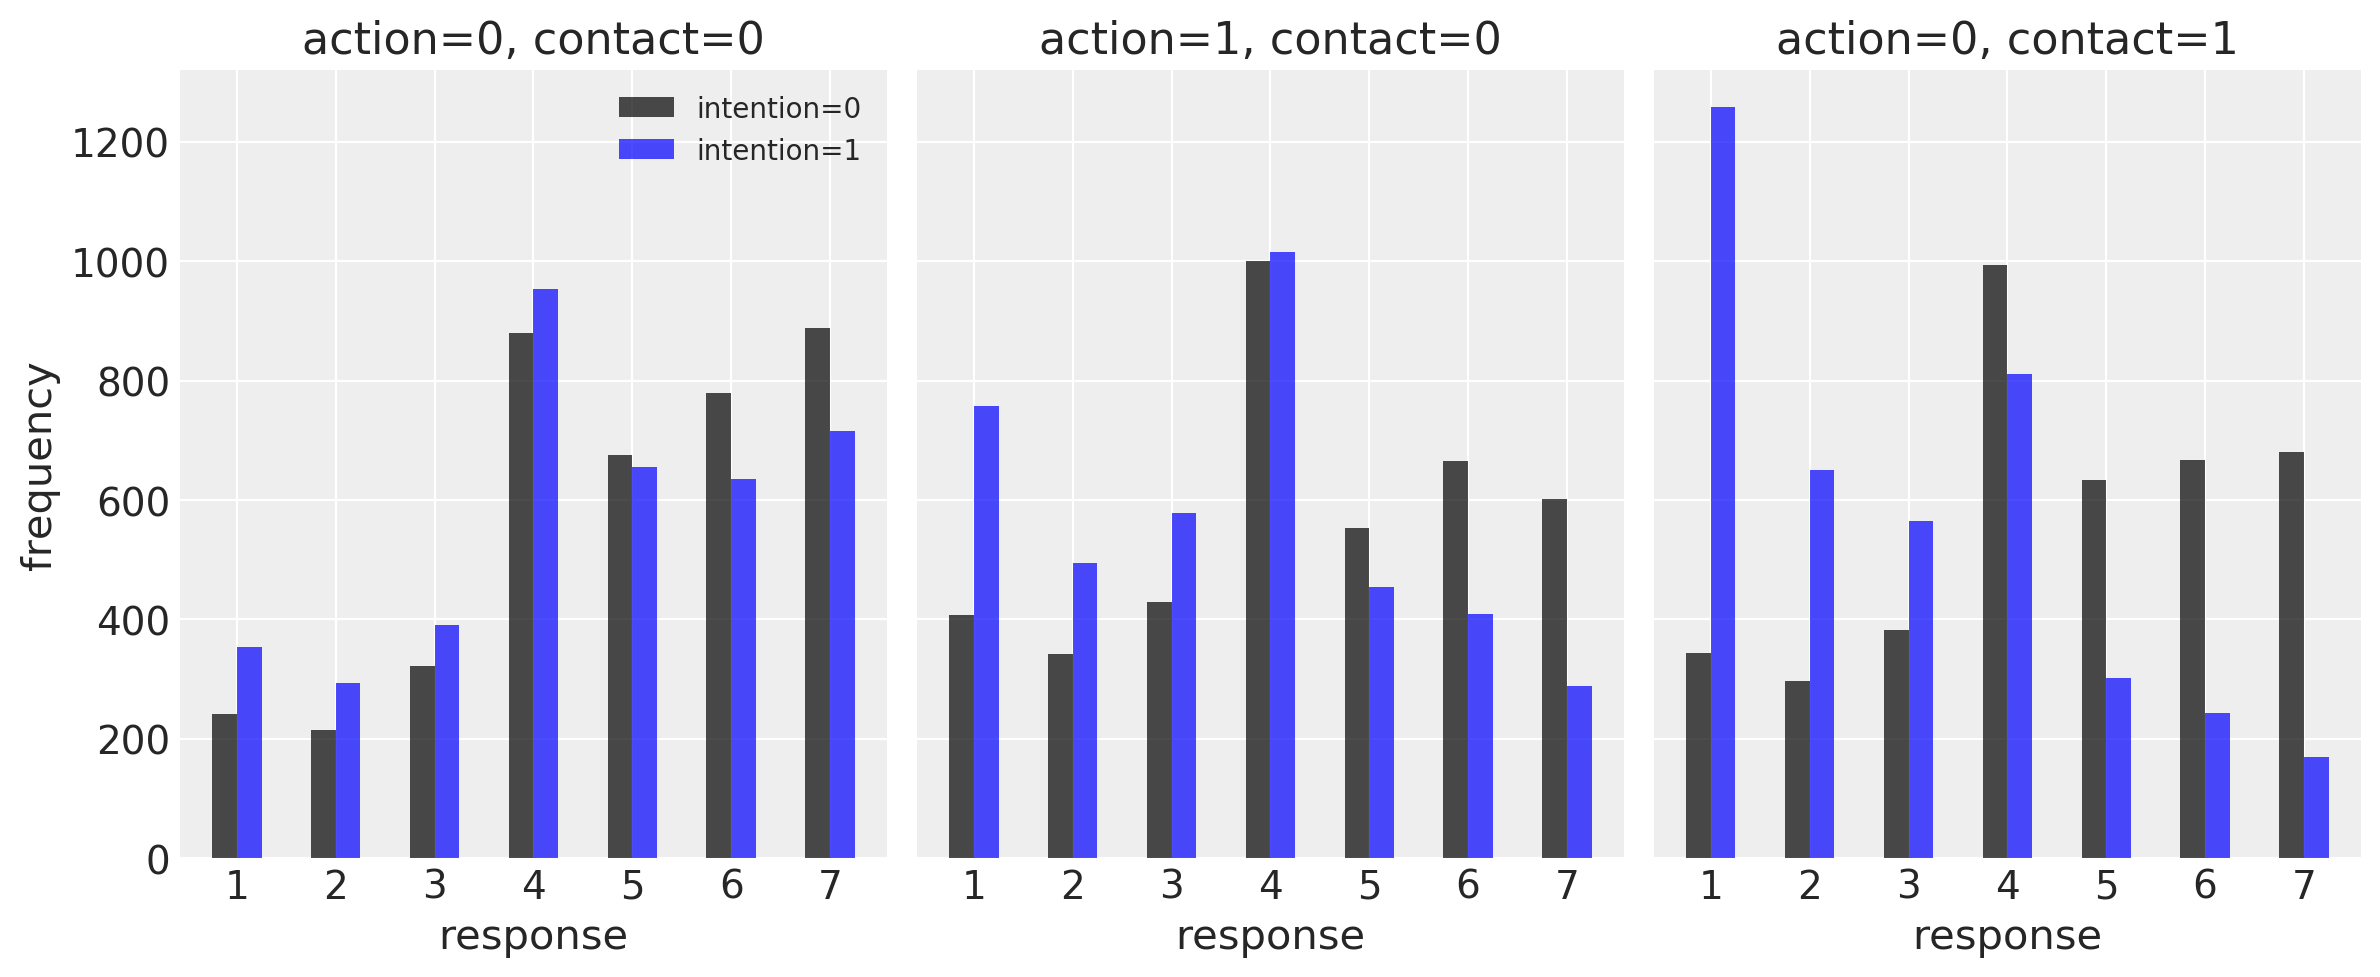

In [37]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")
plt.tight_layout();

#### Code 12.30

In [38]:
pd.Categorical(trolley_df.edu)

[Middle School, Middle School, Middle School, Middle School, Middle School, ..., Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree]
Length: 9930
Categories (8, object): [Bachelor's Degree, Elementary School, Graduate Degree, High School Graduate, Master's Degree, Middle School, Some College, Some High School]

#### Code 12.31

In [39]:
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes

#### Code 12.32

In [40]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

#### Code 12.33

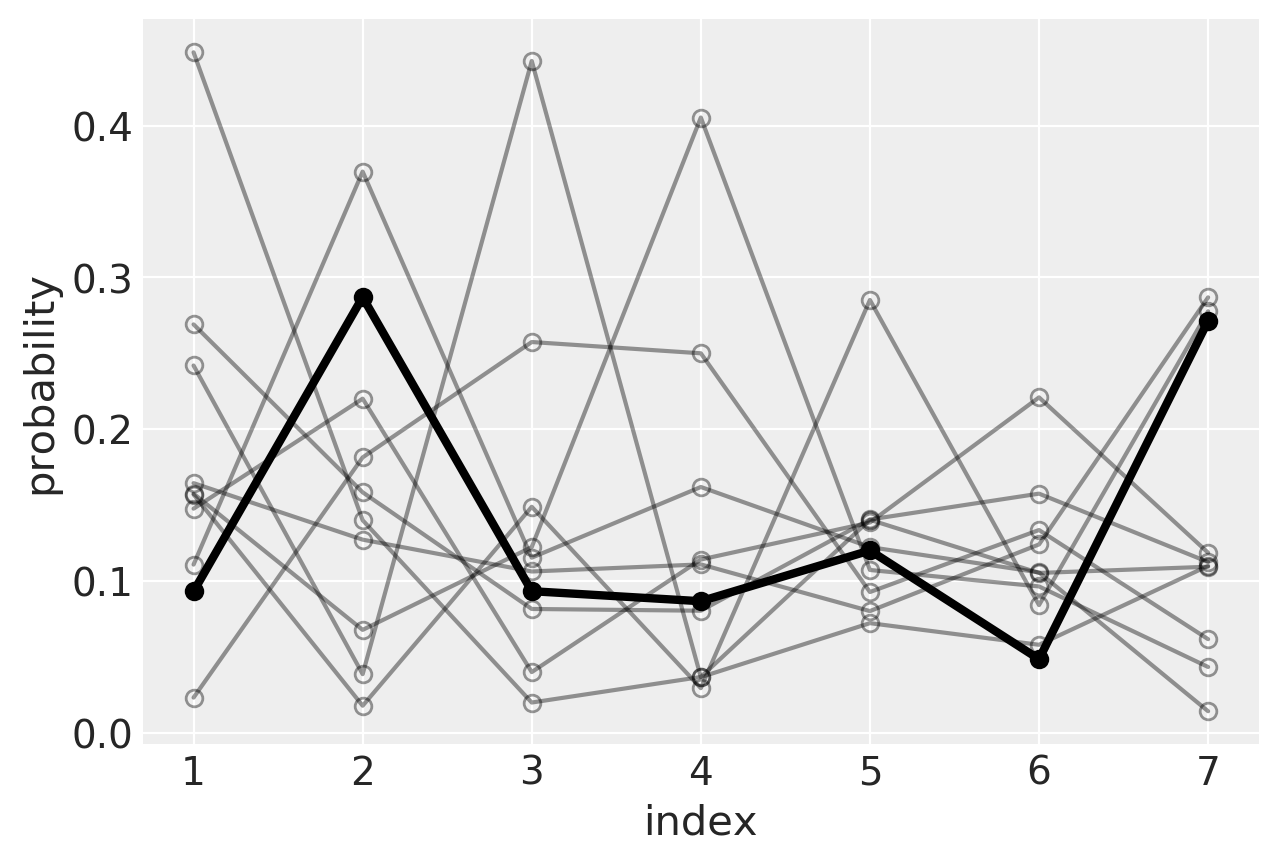

In [41]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

#### Code 12.34

In [42]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values

with pm.Model() as m12_6:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    trace_12_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, kappa]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 665 seconds.


#### Code 12.35

In [43]:
idata = az.from_pymc3(trace_12_6)
az.summary(idata, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.76,-0.63,0.0,0.0,9990.07,9990.07,9996.00,6551.61,1.0
bC,-0.95,0.05,-1.03,-0.87,0.0,0.0,9662.57,9628.85,9608.61,6297.14,1.0
bI,-0.71,0.04,-0.77,-0.66,0.0,0.0,10984.65,10980.29,10981.35,5893.35,1.0
bE,-0.29,0.16,-0.53,-0.04,0.0,0.0,3556.16,3451.83,3661.88,3678.18,1.0
delta[0],0.21,0.13,0.02,0.40,0.0,0.0,6237.78,5570.89,6309.34,5257.06,1.0
delta[1],0.14,0.09,0.01,0.26,0.0,0.0,14485.70,10636.60,12580.66,5153.32,1.0
delta[2],0.19,0.11,0.03,0.35,0.0,0.0,9506.63,8107.80,9029.95,5288.65,1.0
delta[3],0.17,0.10,0.02,0.31,0.0,0.0,9200.11,8075.14,8732.47,5365.69,1.0
delta[4],0.05,0.06,0.00,0.09,0.0,0.0,3083.43,3019.01,5306.42,3598.30,1.0
delta[5],0.10,0.07,0.01,0.19,0.0,0.0,10134.83,8081.59,9728.20,4802.66,1.0


#### Code 12.36

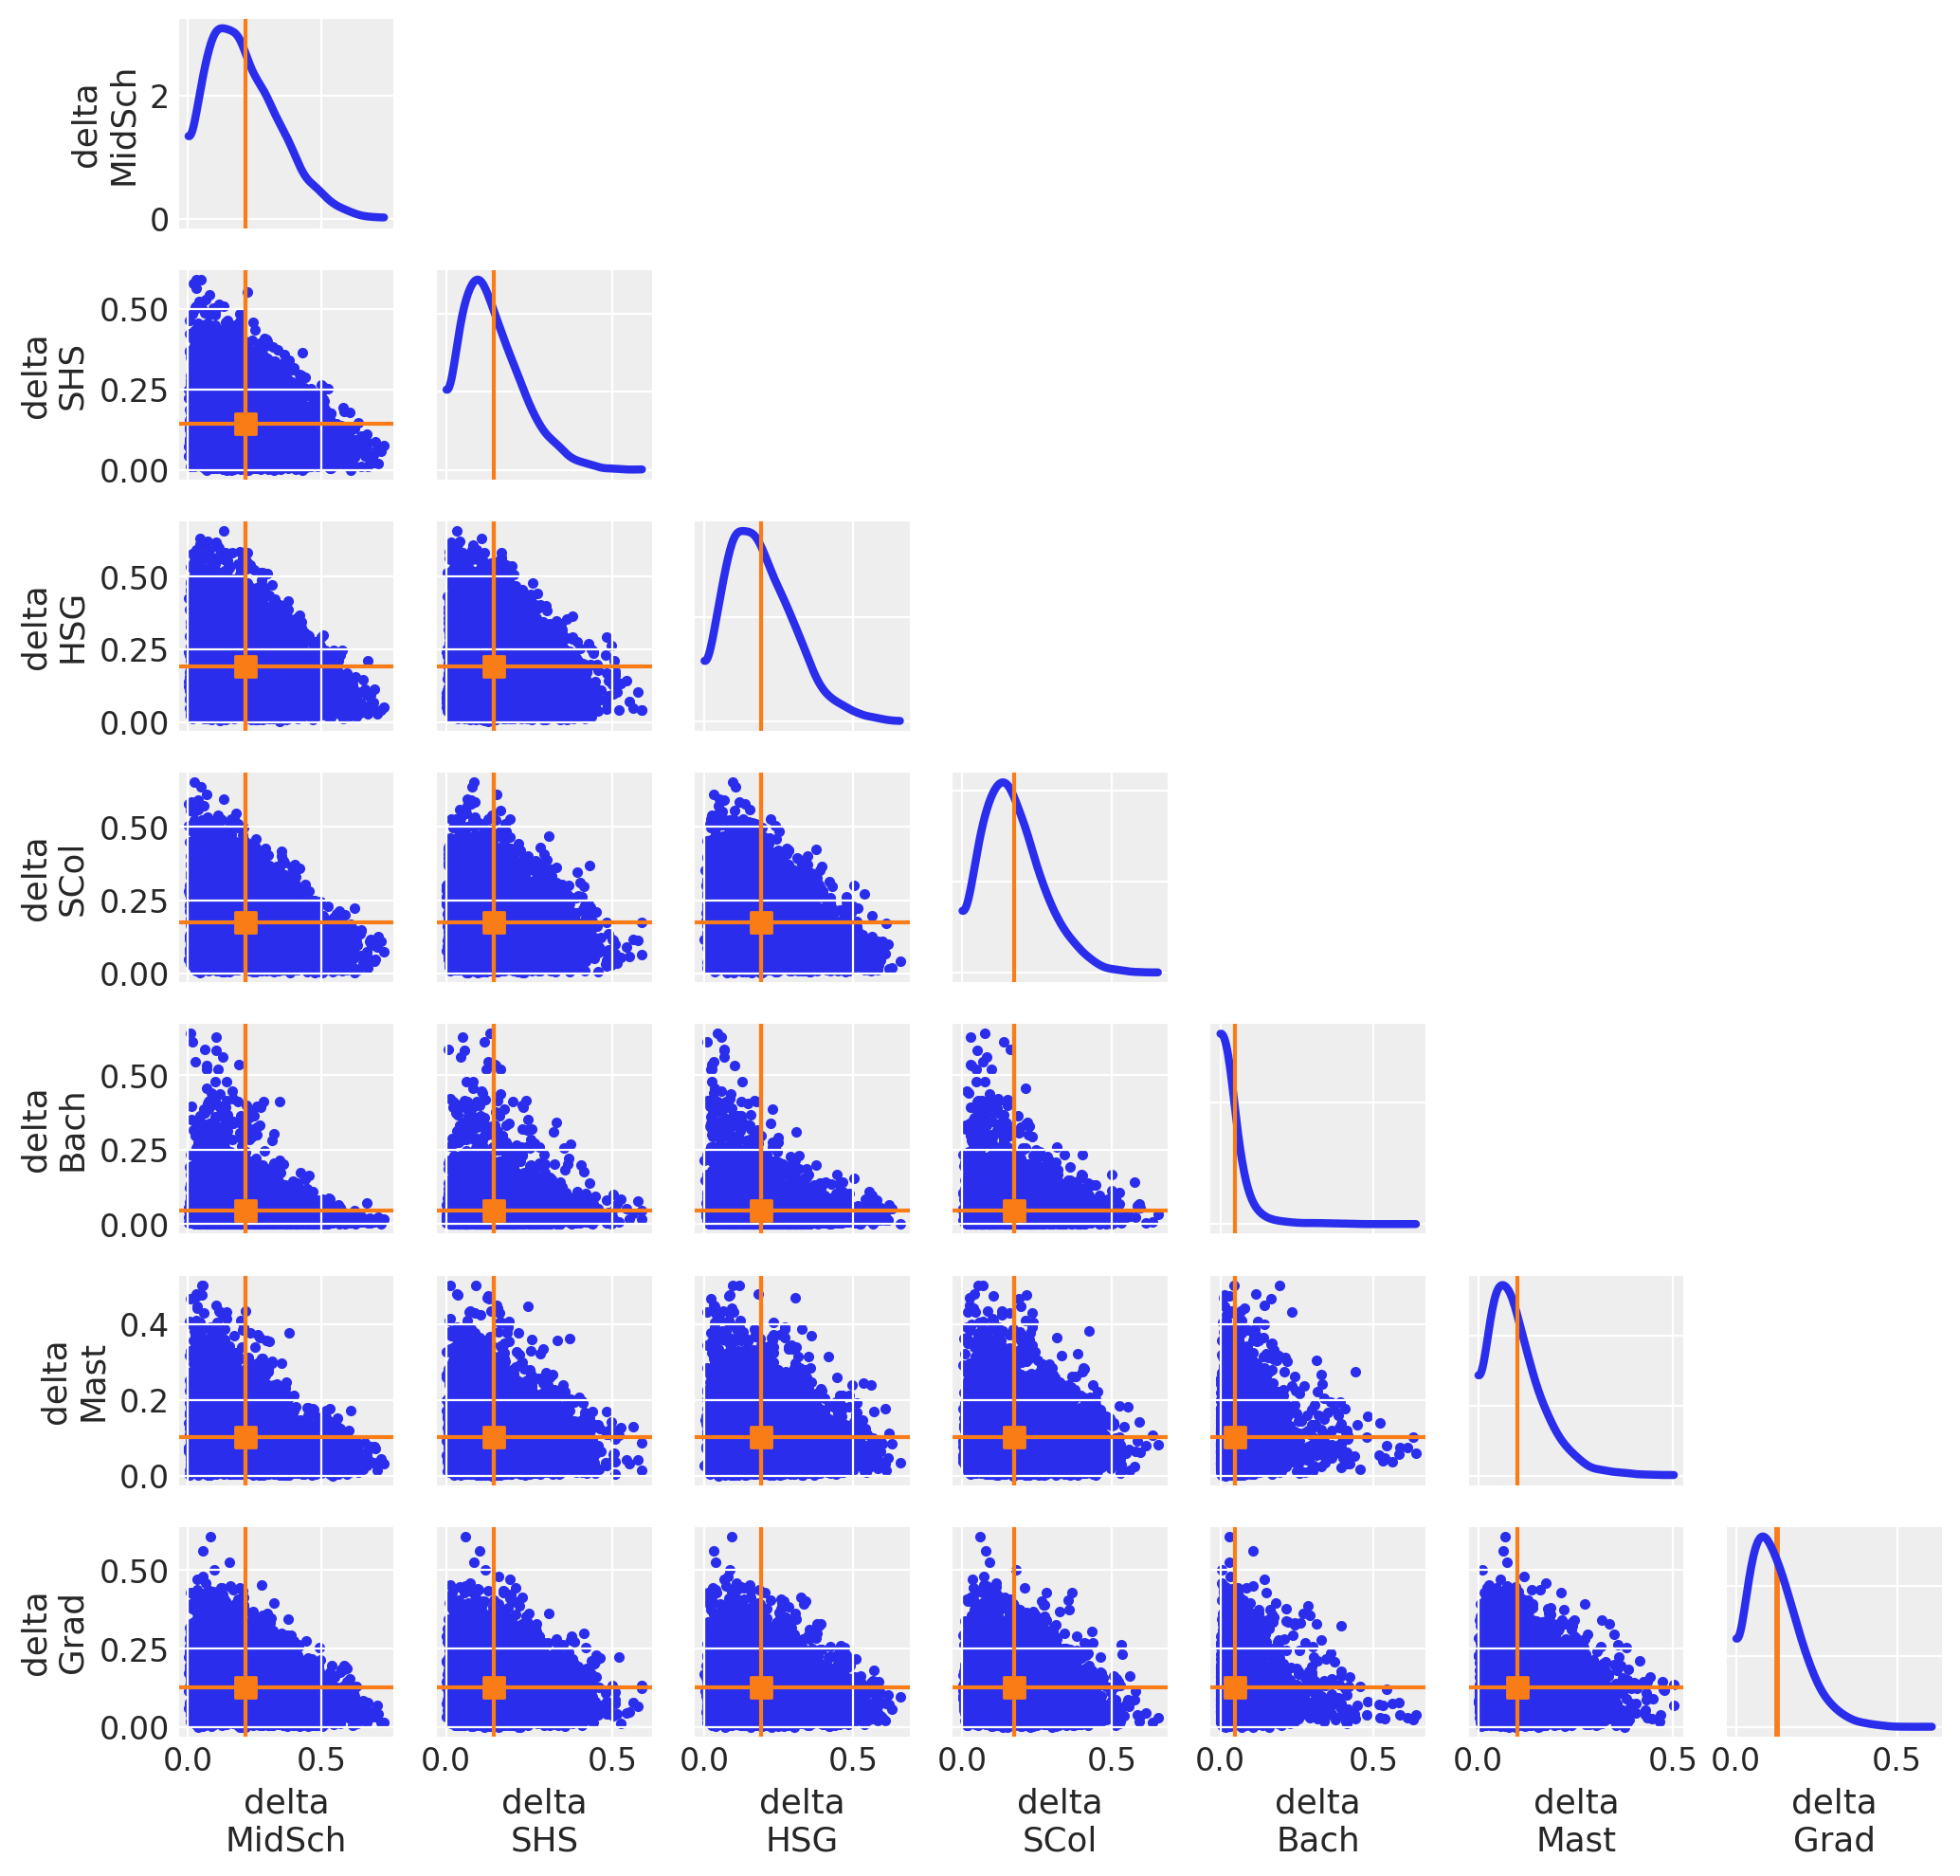

In [44]:
idata.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]
az.plot_pair(
    idata,
    var_names=["delta"],
    diagonal=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
);

#### Code 12.37

In [45]:
edu_norm = (
    (trolley_df.edu_new - trolley_df.edu_new.min())
    / (trolley_df.edu_new.max() - trolley_df.edu_new.min())
).values

with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_7 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_7, var_names=["bA", "bC", "bI", "bE"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bE, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.76,-0.64,0.0,0.0,4312.14,4262.93,4306.03,3284.71,1.0
bC,-0.95,0.05,-1.02,-0.86,0.0,0.0,5549.81,5536.40,5542.27,3638.08,1.0
bI,-0.71,0.04,-0.77,-0.65,0.0,0.0,5460.47,5445.70,5467.95,2615.39,1.0
bE,-0.10,0.09,-0.24,0.05,0.0,0.0,3694.15,3618.36,3696.71,2418.68,1.0


In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

theano     1.0.4
pymc3      3.8
arviz      0.7.0
pandas     0.25.3
numpy      1.18.1
scipy      1.4.1
matplotlib 3.1.3
last updated: Mon Apr 13 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.1
